In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import color
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True


device(type='cuda')

In [2]:
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")
print(f"How many devices {torch.cuda.device_count()}")


Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device:0
Name of current CUDA device: NVIDIA GeForce RTX 4060
How many devices 1


In [3]:
transform = transforms.Compose([transforms.Resize(320),
                                transforms.CenterCrop(320),
                                #transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])
X = datasets.ImageFolder('./datasets/X/', transform=transform)
y = datasets.ImageFolder('./datasets/y/', transform=transform)
X_dataloader = torch.utils.data.DataLoader(X,
                                           batch_size=16,
                                           shuffle=False)
y_dataloader = torch.utils.data.DataLoader(y,
                                           batch_size=16,
                                           shuffle=False)
X_batched_data = iter(X_dataloader)
y_batched_data = iter(y_dataloader)

In [4]:
X = next(X_batched_data)[0]
y = next(y_batched_data)[0]

In [5]:
X.size()

torch.Size([16, 3, 320, 320])

In [6]:
y.size()

torch.Size([16, 3, 320, 320])

In [7]:
X

tensor([[[[0.6471, 0.6471, 0.6471,  ..., 0.8392, 0.8392, 0.8392],
          [0.6471, 0.6471, 0.6471,  ..., 0.8392, 0.8392, 0.8392],
          [0.6471, 0.6471, 0.6471,  ..., 0.8392, 0.8392, 0.8392],
          ...,
          [0.1098, 0.1098, 0.1098,  ..., 0.3294, 0.3294, 0.3294],
          [0.1098, 0.1098, 0.1098,  ..., 0.3294, 0.3294, 0.3294],
          [0.1098, 0.1098, 0.1098,  ..., 0.3294, 0.3294, 0.3294]],

         [[0.7294, 0.7294, 0.7294,  ..., 0.8471, 0.8471, 0.8471],
          [0.7294, 0.7294, 0.7294,  ..., 0.8471, 0.8471, 0.8471],
          [0.7294, 0.7294, 0.7294,  ..., 0.8471, 0.8471, 0.8471],
          ...,
          [0.1216, 0.1216, 0.1216,  ..., 0.3647, 0.3647, 0.3647],
          [0.1216, 0.1216, 0.1216,  ..., 0.3647, 0.3647, 0.3647],
          [0.1216, 0.1216, 0.1216,  ..., 0.3647, 0.3647, 0.3647]],

         [[0.6078, 0.6078, 0.6078,  ..., 0.7529, 0.7529, 0.7529],
          [0.6078, 0.6078, 0.6078,  ..., 0.7529, 0.7529, 0.7529],
          [0.6078, 0.6078, 0.6078,  ..., 0

In [8]:
y

tensor([[[[0.4784, 0.4824, 0.4902,  ..., 0.4902, 0.4863, 0.4824],
          [0.4784, 0.4824, 0.4902,  ..., 0.4941, 0.4902, 0.4863],
          [0.4824, 0.4863, 0.4902,  ..., 0.5020, 0.4980, 0.4941],
          ...,
          [0.0667, 0.0667, 0.0627,  ..., 0.3608, 0.3804, 0.3608],
          [0.0745, 0.0667, 0.0549,  ..., 0.4157, 0.4118, 0.4275],
          [0.0784, 0.0706, 0.0549,  ..., 0.4745, 0.4549, 0.4667]],

         [[0.5882, 0.5922, 0.6000,  ..., 0.5882, 0.5843, 0.5804],
          [0.5882, 0.5922, 0.6000,  ..., 0.5922, 0.5882, 0.5843],
          [0.5922, 0.5961, 0.6000,  ..., 0.6000, 0.5961, 0.5922],
          ...,
          [0.0784, 0.0784, 0.0745,  ..., 0.4118, 0.4353, 0.4157],
          [0.0941, 0.0824, 0.0667,  ..., 0.4667, 0.4627, 0.4784],
          [0.1020, 0.0863, 0.0706,  ..., 0.5255, 0.5059, 0.5137]],

         [[0.4980, 0.5020, 0.5098,  ..., 0.5020, 0.4980, 0.4941],
          [0.4980, 0.5020, 0.5098,  ..., 0.5059, 0.5020, 0.4980],
          [0.5020, 0.5059, 0.5098,  ..., 0

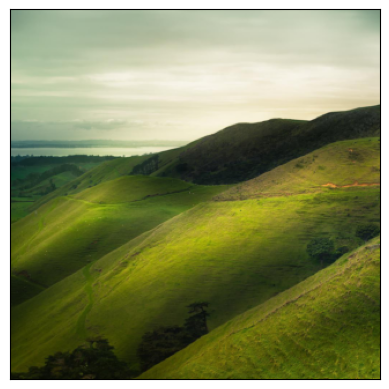

In [9]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', length=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.imshow(y[0].numpy().transpose((1, 2, 0)))

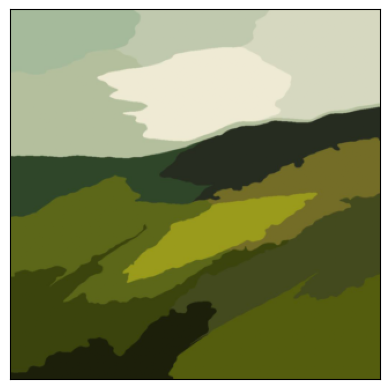

In [10]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', length=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.imshow(X[0].numpy().transpose((1, 2, 0)))

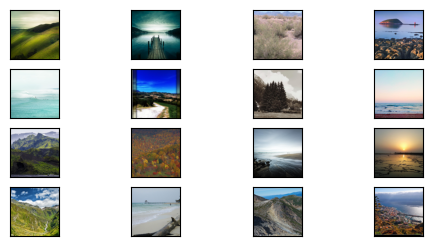

In [11]:
plt.figure(figsize=(6, 6))
for n, img in enumerate(y):
    ax = plt.subplot(8, 4, n + 1)

    ax.imshow(img.numpy().transpose((1, 2, 0)))
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels("")
    ax.set_yticklabels("")

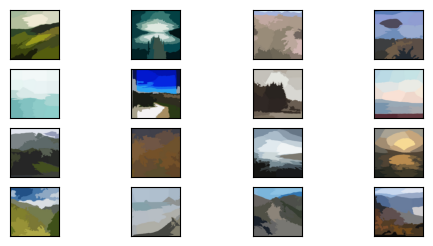

In [12]:
plt.figure(figsize=(6, 6))
for n, img in enumerate(X):
    ax = plt.subplot(8, 4, n + 1)

    ax.imshow(img.numpy().transpose((1, 2, 0)))
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels("")
    ax.set_yticklabels("")

In [13]:
class Improver(torch.nn.Module):
    def __init__(self):
        super(Improver, self).__init__()
        self.fc1 = torch.nn.Linear(320 * 320, 4096)
        self.ac1 = torch.nn.LeakyReLU()
        self.fc2 = torch.nn.Linear(4096, 2048)
        self.ac2 = torch.nn.LeakyReLU()
        self.fc3 = torch.nn.Linear(2048, 320 * 320)
        self.ac3 = torch.nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 320 * 320)
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = x.view(-1, 1, 320, 320)
        x = self.ac3(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(nn.Linear(320 * 320, 512),
                                    nn.LeakyReLU())
        self.layer2 = nn.Sequential(nn.Linear(512, 128),
                                    nn.LeakyReLU())
        self.output = nn.Sequential(nn.Linear(128, 1),
                                    nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 320 * 320)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x

In [14]:
D = Discriminator().to(device)
I = Improver().to(device)
loss = nn.BCELoss()

D_optimizer = torch.optim.SGD(D.parameters(), lr=0.003)
I_optimizer = torch.optim.Adam(I.parameters(), lr=0.0003)
for e in range(30):
    for i, ((noises, _), (real, _)) in enumerate(zip(cycle(X_dataloader), y_dataloader)):
        real_inputs = real.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)
        noise = noises.to(device)
        fake_inputs = I(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)
        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)
        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        fake_inputs = I(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        I_loss = loss(fake_outputs, fake_targets)
        I_optimizer.zero_grad()
        I_loss.backward()
        I_optimizer.step()
        if i % 100 == 0 or i == len(X_dataloader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(e, i, D_loss.item(),
                                                                                                  I_loss.item()))
    if (e + 1) % 10 == 0:
        torch.save(I, 'Generator_epoch_{}.pth'.format(e))
        print('Model saved.')

Epoch 0 Iteration 0: discriminator_loss 0.691 generator_loss 0.761
Epoch 0 Iteration 100: discriminator_loss 0.307 generator_loss 1.618
Epoch 0 Iteration 200: discriminator_loss 0.032 generator_loss 4.245
Epoch 1 Iteration 0: discriminator_loss 0.039 generator_loss 3.781
Epoch 1 Iteration 100: discriminator_loss 0.090 generator_loss 3.440
Epoch 1 Iteration 200: discriminator_loss 0.094 generator_loss 3.031
Epoch 2 Iteration 0: discriminator_loss 0.018 generator_loss 4.588
Epoch 2 Iteration 100: discriminator_loss 0.004 generator_loss 5.857
Epoch 2 Iteration 200: discriminator_loss 0.023 generator_loss 4.359
Epoch 3 Iteration 0: discriminator_loss 0.046 generator_loss 3.736
Epoch 3 Iteration 100: discriminator_loss 0.018 generator_loss 4.207
Epoch 3 Iteration 200: discriminator_loss 0.026 generator_loss 4.440
Epoch 4 Iteration 0: discriminator_loss 0.021 generator_loss 4.339
Epoch 4 Iteration 100: discriminator_loss 0.027 generator_loss 4.093
Epoch 4 Iteration 200: discriminator_loss 0.


KeyboardInterrupt



for i, ((noises,_),(real,_)) in enumerate(zip(cycle(X_dataloader), y_dataloader)):
    for img in noises:
        ax = plt.subplot(8, 4, n + 1)
    
        ax.imshow(img.numpy().transpose((1, 2, 0)))
        ax.tick_params(axis='both', length=0)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        #plt.imshow(noises[0].detach().numpy().squeeze())
    

print(noise.view(-1,640*640).size())

In [18]:
x = torch.rand(3, 320, 320)
conv1 = nn.Conv2d(in_channels=3,
                  out_channels=3,
                  kernel_size=1,
                  stride=1,
                  padding=0)
print(conv1(x).size())
x = conv1(x)
maxpool1 = nn.MaxPool2d((2,2), stride=2)
print(maxpool1(x).size())
x = maxpool1(x)

torch.Size([3, 320, 320])
torch.Size([3, 160, 160])


In [25]:
x = torch.rand(1, 32, 32)
conv1 = nn.Conv2d(in_channels=1,
                  out_channels=6,
                  kernel_size=5,
                  stride=1,
                  padding=0)
print(conv1(x).size())
x = conv1(x)

maxpool1 = nn.MaxPool2d((2,2),stride=2)
print(maxpool1(x).size())


print()

torch.Size([6, 28, 28])
torch.Size([6, 14, 14])


In [55]:
x = torch.rand(3,224,224)
conv1 = nn.Conv2d(in_channels=3,
                  out_channels=96,
                  kernel_size=(11,11),
                  stride = 4, padding=1)
print(conv1(x).size())

torch.Size([96, 54, 54])
